<a href="https://colab.research.google.com/github/safaeOulaja/Embedding-Search-NTCIR-CLEF-TREC/blob/main/Embedding%2BSearch_CLEF_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Code for Embedding and Searching IAPR TC-12 Dataset - ImageCLEF/IAPR TC 12 Photo Collection**



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset
!wget http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz -O iaprtc12.tgz

# Extract the dataset
!tar -xvzf iaprtc12.tgz -C /content/

Streaming output truncated to the last 5000 lines.
iaprtc12/images/32/32281.jpg
iaprtc12/images/32/32282.jpg
iaprtc12/images/32/32283.jpg
iaprtc12/images/32/32284.jpg
iaprtc12/images/32/32285.jpg
iaprtc12/images/32/32286.jpg
iaprtc12/images/32/32287.jpg
iaprtc12/images/32/32288.jpg
iaprtc12/images/32/32289.jpg
iaprtc12/images/32/32290.jpg
iaprtc12/images/32/32291.jpg
iaprtc12/images/32/32292.jpg
iaprtc12/images/32/32293.jpg
iaprtc12/images/32/32294.jpg
iaprtc12/images/32/32295.jpg
iaprtc12/images/32/32296.jpg
iaprtc12/images/32/32297.jpg
iaprtc12/images/32/32298.jpg
iaprtc12/images/32/32299.jpg
iaprtc12/images/32/32300.jpg
iaprtc12/images/32/32301.jpg
iaprtc12/images/32/32302.jpg
iaprtc12/images/32/32303.jpg
iaprtc12/images/32/32304.jpg
iaprtc12/images/32/32305.jpg
iaprtc12/images/32/32306.jpg
iaprtc12/images/32/32307.jpg
iaprtc12/images/32/32308.jpg
iaprtc12/images/32/32309.jpg
iaprtc12/images/32/32310.jpg
iaprtc12/images/32/32311.jpg
iaprtc12/images/32/32312.jpg
iaprtc12/images/32/32

In [ ]:
# Navigate into the extracted folder
!ls /content/iaprtc12

additional_images  annotations_complete_eng  annotations_complete_random
annotations	   annotations_complete_ger  images


In [ ]:
# Imports and Model Loading
import os
import re
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Load the pre-trained model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Step 2: Define CLEF dataset path and read annotations
annotations_path = "/content/iaprtc12/annotations_complete_eng"

print(annotations_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/content/iaprtc12/annotations_complete_eng


In [ ]:
# Annotation Example
!cat /content/iaprtc12/annotations_complete_eng/00/112.eng

<DOC>
<DOCNO>annotations/00/112.eng</DOCNO>
<TITLE>Excursion with the godchildren</TITLE>
<DESCRIPTION>About 20 kids in traditional clothing and hats waiting on stairs; a house and a green wall with gate in the background; a sign saying that plants can't be picked up on the right;</DESCRIPTION>
<NOTES></NOTES>
<LOCATION>Quilotoa, Ecuador</LOCATION>
<DATE>April 2002</DATE>
<IMAGE>images/00/112.jpg</IMAGE>
<THUMBNAIL>thumbnails/00/112.jpg</THUMBNAIL>
</DOC>

In [ ]:
# Step 2: Modify the parse_annotation function to include the IMAGE path
def parse_annotation(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()

    # Extract fields using regex
    title = re.search(r"<TITLE>(.*?)</TITLE>", content).group(1).strip() if re.search(r"<TITLE>(.*?)</TITLE>", content) else ""
    description = re.search(r"<DESCRIPTION>(.*?)</DESCRIPTION>", content).group(1).strip() if re.search(r"<DESCRIPTION>(.*?)</DESCRIPTION>", content) else ""
    image_path = re.search(r"<IMAGE>(.*?)</IMAGE>", content).group(1).strip() if re.search(r"<IMAGE>(.*?)</IMAGE>", content) else ""

    # Combine the title and description for embedding and search
    combined_text = f"{title}. {description}"

    return combined_text, image_path

# Step 3: Create DataFrame with Image Paths
data = []
for folder in os.listdir(annotations_path):
    folder_path = os.path.join(annotations_path, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            combined_text, image_path = parse_annotation(file_path)
            data.append({'File_Path': file_path, 'Combined_Text': combined_text, 'Image_Path': image_path})

# Convert to DataFrame
df = pd.DataFrame(data)

df.head()

,File_Path,Combined_Text,Image_Path
0,/content/iaprtc12/annotations_complete_eng/14/...,The group on a bridge in front of the Peguche ...,images/14/14158.jpg
1,/content/iaprtc12/annotations_complete_eng/14/...,"Lima at Night. a square with palms, burning st...",images/14/14342.jpg
2,/content/iaprtc12/annotations_complete_eng/14/...,Beautiful landscape during the train ride. a b...,images/14/14553.jpg
3,/content/iaprtc12/annotations_complete_eng/14/...,Guanacos. brown and white guanacos in an enclo...,images/14/14148.jpg
4,/content/iaprtc12/annotations_complete_eng/14/...,Hiking break. eight tourists are posing in fro...,images/14/14026.jpg


In [ ]:
# Step 4: Embed the 'Combined_Text' column
df['Embedding_Vector'] = df['Combined_Text'].apply(lambda x: model.encode(x))

In [ ]:
from IPython.display import Image, display

# Step 5: Update the Search Function to Display Image Paths
def search_review(model, df, query, n=10):
    # Generate the embedding vector for the query sentence
    query_embedding = model.encode([query])

    # Calculate cosine similarity between the query embedding and each embedding in 'Embedding_Vector'
    df['Cosine_Similarity'] = df['Embedding_Vector'].apply(
        lambda x: cosine_similarity([query_embedding[0]], [x])[0][0]
    )

    # Sort by cosine similarity in descending order and return the top 'n' results with images
    top_n_df = df.sort_values(by='Cosine_Similarity', ascending=False).head(n)
    # Display results with images
    for index, row in top_n_df.iterrows():
        print(f"File Path: {row['File_Path']}")
        print(f"Combined Text: {row['Combined_Text']}")
        print(f"Cosine Similarity: {row['Cosine_Similarity']:.4f}")

        # Construct the full image path
        full_image_path = os.path.join("/content/iaprtc12", row['Image_Path'])

        # Display the image
        display(Image(filename=full_image_path, width=200))
        print("\n")

File Path: /content/iaprtc12/annotations_complete_eng/00/25.eng
Combined Text: The Plaza de Armas. a yellow building with white columns in the background; two palm trees in front of the house; cars parked in front of the house; a woman and a child are walking over the square;
Cosine Similarity: 0.8161


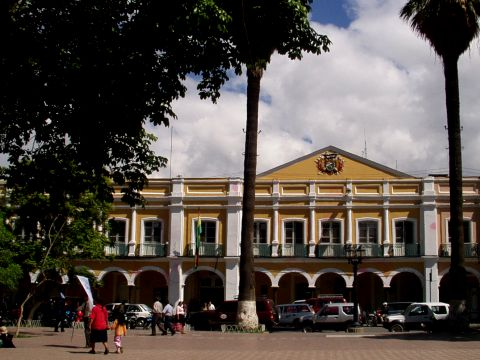



File Path: /content/iaprtc12/annotations_complete_eng/00/26.eng
Combined Text: Plaza de Armas. a large building on the left, a palm tree in centre of picture, (mostly) white cars in the street at a junction, some of them turning left, others going straight; there are red umbrellas in a park on the right; people are walking through the park, others are crossing the road in the foreground;
Cosine Similarity: 0.7976


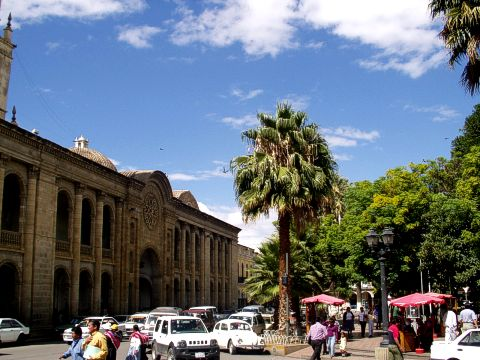



File Path: /content/iaprtc12/annotations_complete_eng/06/6790.eng
Combined Text: The Plaza de Armas. a square with a lawn, many palm trees, street lamps, a fountain and a brown building with two flags in the background;
Cosine Similarity: 0.7901


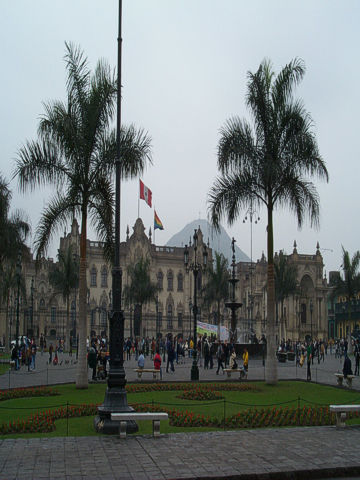



File Path: /content/iaprtc12/annotations_complete_eng/07/7074.eng
Combined Text: The Plaza de Armas. people on a concrete square with a palm tree, lawns, flowers and street lamps and a grey cathedral with a yellow tower in the background;
Cosine Similarity: 0.7875


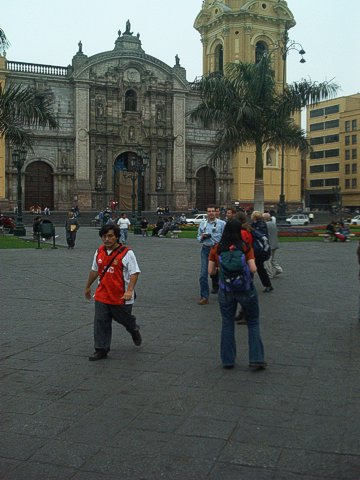



File Path: /content/iaprtc12/annotations_complete_eng/05/5116.eng
Combined Text: The Plaza de Armas. a square with a lawn, red and purple flowers, a palm tree and street lamps; a big, yellow window with white ornaments, white columns, a white balcony, yellow arches and black windows in the background;
Cosine Similarity: 0.7760


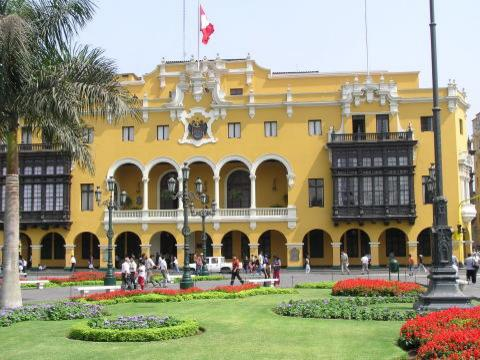



File Path: /content/iaprtc12/annotations_complete_eng/07/7246.eng
Combined Text: The Plaza de Armas in Lima. a square with palm trees, green spaces, yellow and red flowers, street lamps and many people; two big yellow buildings in the background;
Cosine Similarity: 0.7720


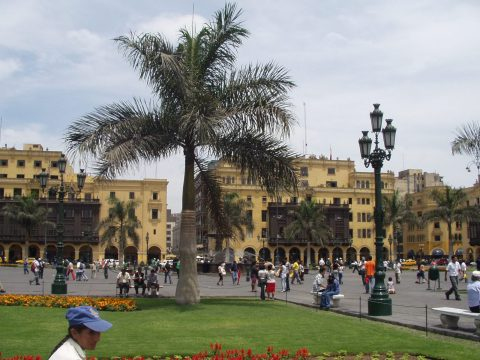



File Path: /content/iaprtc12/annotations_complete_eng/07/7058.eng
Combined Text: The Plaza de Armas. a fountain on a square with many palm trees, other threes, green areas, birds and people; a grey two-storey building with many arches and two flags on the roof;
Cosine Similarity: 0.7663


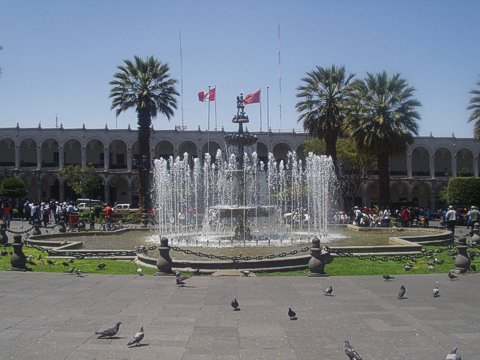



File Path: /content/iaprtc12/annotations_complete_eng/19/19820.eng
Combined Text: Plaza de Armas in Lima. an illuminated park with palms, green spaces, flowers, a statue and many street lamps, surround by yellow (or yellow-illuminated) buildings;
Cosine Similarity: 0.7502


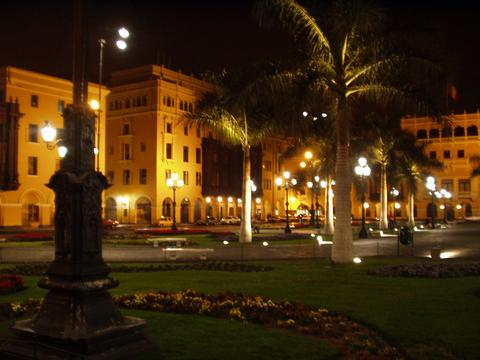



File Path: /content/iaprtc12/annotations_complete_eng/16/16705.eng
Combined Text: The Plaza de Armas in Lima. a large, dark yellow building with many arches, white columns, black balconies and a flag on it; people on a grey square with two palms, street lamps, green spaces and red flowers in the foreground; a grey sky in the background;
Cosine Similarity: 0.7438


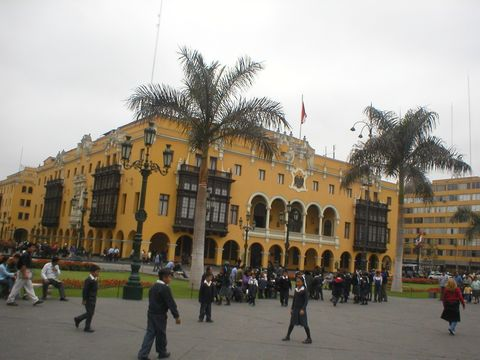



File Path: /content/iaprtc12/annotations_complete_eng/04/4423.eng
Combined Text: The Plaza de Armas at night. an illuminated park with palms, green spaces, flowers, a statue and many street lamps, surround by yellow (or yellow-illuminated) buildings;
Cosine Similarity: 0.7410


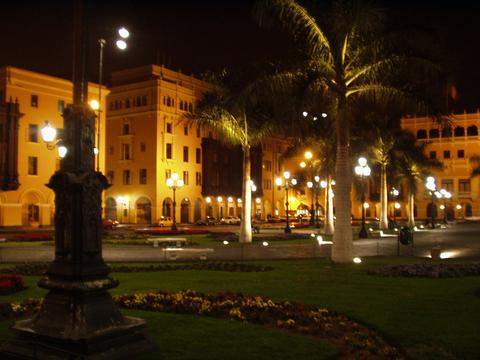

In [ ]:
# Example usage of search function
query = 'Plaza de Armas, yellow building, palm trees.'
search_review(model, df, query)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(df, query, n=30, threshold=0.70):
    # Generate the query embedding
    query_embedding = model.encode([query])

    # Calculate cosine similarity
    df['Cosine_Similarity'] = df['Embedding_Vector'].apply(
        lambda x: cosine_similarity([query_embedding[0]], [x])[0][0]
    )

    # Sort by similarity and get top 'n' results
    top_n_df = df.sort_values(by='Cosine_Similarity', ascending=False).head(n)

    # Simulate relevance: 1 if similarity above threshold, else 0
    top_n_df['Relevance'] = top_n_df['Cosine_Similarity'].apply(lambda x: 1 if x >= threshold else 0)

    # Precision@30
    precision_at_30 = top_n_df['Relevance'].head(30).mean()

    # Recall@30
    actual_relevant = top_n_df['Relevance'].sum()
    recall_at_30 = top_n_df['Relevance'].head(30).sum() / actual_relevant if actual_relevant else 0

    # F1-Score
    f1 = f1_score([1] * actual_relevant, top_n_df['Relevance'].head(actual_relevant).tolist()) if actual_relevant else 0

    # MAP: Calculate precision at each relevant position and average
    avg_precision = 0
    relevant_count = 0
    for i, relevance in enumerate(top_n_df['Relevance'], start=1):
        if relevance == 1:
            relevant_count += 1
            avg_precision += relevant_count / i
    map_score = avg_precision / relevant_count if relevant_count else 0

    # Display metrics
    print(f"Precision@30: {precision_at_30:.4f}")
    print(f"Recall@30: {recall_at_30:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"MAP: {map_score:.4f}")

# Example usage of calculate_metrics function
query = 'Plaza de Armas, yellow building, palm trees.'
calculate_metrics(df, query)

Precision@30: 1.0000
Recall@30: 1.0000
F1-score: 1.0000
MAP: 1.0000
